# Using BERT to quantify the predictability of writing style

Transformer-based models of language such as BERT have been used create state-of-the-art models for a wide range of NLP tasks over the past few years. 
BERT's next-sentence prediction's capability have recently been used to <a href='https://tedunderwood.com/2020/07/05/how-predictable-is-fiction/'>assess the predictability of fiction.</a> 
This notebook attempts to use another task that BERT can be trained on, masked language modeling, to assess the predictability of style within a single sentence.

In lay language, masked language modeling can be described as a fill-in-the-blanks task. A model is given a sentence, each token in the sentence is hidden and the model made to predict it using the surrounding context words. The idea is that we can use the probabilities generated by such a model to assess how predictable the style of a sentence is. For instance, in the following English language sentence:

    His hair as gold as the sun , his eyes blue like the [MASK].

BERT (English) can predict `sky` with a 27.1% probability. But in the this sentence:

    `The [MASK] above the port was the color of television, tuned to a dead channel`

the probability of `sky` falls much lower, with BERT instead giving tokens such as `screen`, `window` or `panel` the highest probabilities - since the comparison to television makes the presence of the word less predictable. In short, BERT is better at predicting boilerplate than original writing. 

<br>
<br>

I would like to extend this beyond the scope of a single word and onto the scale of a complete sentence, i.e. evaluating a sentence's predictability. This approach makes sense because the way BERT computes probability would reflect a couple of things typically associated with literary originality: 
- the "preciosity" of a word (given two synonyms, the rarer one will receive a lower probability)
- the unexpectedness of comparison and literary or poetic language (we might say, in structuralist terms, that BERT's probabilities are computed following paradigmatic (predicting a word over others) and syntagmatic (based on its context) axes, whose order are subverted by the "poetic function" of language)

This predictability score could then be used as a metric for literary creativity. Being able to quantify such a value would be interesting for literary history and comparative literature, for instance if we were to compare it against signs of literary recognition (literary prizes, publication in prestigious or non-prestigious publishing houses...), enabling us to evaluate how much a certain literary culture values conformity over creativity (or vice-versa) at a certain point in time.

<br>
<br>

The insight that a language model can be used to assert how "common" the style of sentence is not entirely new. The scoring of sentences by language models, known as <a href='https://en.wikipedia.org/wiki/Perplexity#:~:text=of%20size%20N).-,Perplexity%20per%20word,over%20entire%20sentences%20or%20texts.'>perplexity</a> has been used in tasks such as automatic translation to rate which of the outputs of a model might be the most well-formed sentence in a particular target language. The main differences with our case are that:
1. Traditional language models are sequential, working from left to right. They do not use the whole sentence as context to predict a single word. Some models combine left-to-right models with right-to-left models, but the process is still different from BERT since the probability is computed from the knowledge of what comes before only and what comes after only, not on the entire context.
2. Working with literary texts, we can assume that the sentences we will feed into the model will be generally gramatically correct (or intentionally incorrect). This allows us to be more selective in the categories of word we want to evaluate, skipping pronouns or particles (*still requires further investigation*).

Regarding point 1, BERT gives us an advantage over sequential language models. Because it is bi-directional, it allows us to consider the context on both sides of a word, which is closer to how a human reader would assert the unexpectedness of a single word within a sentence. 

<a href=' https://arxiv.org/pdf/1906.00363.pdf'>Wang et al (2019)</a> averaged the probabilities of the tokens in a sentence ($\prod_{i=1}^{n}p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n}))^{-1/n} $) to predict whether a sentence is non-sensical or not - similar to how the perplexity score is used by sequential language models. 

<a href='https://assets.amazon.science/cc/54/980cb7d74f93849b49b9d5c42466/masked-language-model-scoring.pdf'>Salazar et al (2020)</a> develop a measure of "pseudo-perplexity" to rank sentences with BERT by used log probabilities. This pseudo-perplexity is defined as: $exp(-1/n\sum_{i=1}^{n}log(p(w_{i}|w_{1},...,w_{i-1},w_{i+1},...,w_{n})))) $. This is the measure we'll rely on. 

Point 2 is tied to language specific issues, adressed in the "Language specifics" section below.

### Issues with the metric

Perplexity score is traditionally used to rank different versions of the *same sentence* when generating text with a language model. Because the variation between such sentences is limited, it seems that the behavior of the perplexity score across widely different sentences (as we are doing here) is still unexplored. 
Differences in perplexity scores are minimal. Probabilities for every word tend to be low, but the absolute value hardly matters, the differential from the next word's probability is important. The difference in the mean values of the sentences of our corpus will likewise be tiny, statistical significance may be achieved because of large sample size, but whether that indeed represents an actual effect is less certain.

### Language specifics

Working with Korean and with literary texts, the above formula seems to present some limitations. For instance, Korean can mark the object of a verb with a specific particle (를/을). Predicting this particle being present between a noun and a verb is not hard (tokenizers such as BERT's separate it from the noun to which it would be attached). Therefore the token would be assigned a high probability. However, case particles can and are often omitted depending on context and individual preferences. Including it in the scoring of a sentence might therefore introduce bias, ranking writers who use it extensively as less creative than writers who use it more sparingly. On the other hand, as noted in Point 2 above, we are not interested in evaluating the grammatical correctness of a sentence, and therefore including case particles bring little additional information to our metric. The same is true of punctuation, pronouns, prepositions... We therefore opt to restrict the model to predicting masked nouns, adjectives and verbs (all tokens are still nonetheless used as context).

### Technical specifics

This approach requires us to be able to control the tokenization process because we want to be able to select the words which we will mask for prediction. Because most implementations of BERT uses a type of tokenizer that works splitting more complex words into smaller words to retain a small vocabulary size. This choice of tokenizing method is a powerful way to deal with out-of-vocabulary words (they will be split into smaller, in-vocabulary pieces). 

To address this issue, I've pre-tokenized the training data used during fine-tuning. I then train a new tokenizer with a large dictionary size and use its vocabulary to update the tokenizer's vocabulary of the base BERT model used for fine-tuning. (see <a href='https://github.com/digitalprk/sih_notebooks/blob/master/run_language_modeling.py'>here</a>). (Note that this extra step would not be needed if we did not want to exclude certain grammatical categories: we could simply use the mean of the probabilities of the differents parts of a word that was split as the probability of that word).

The base model used was <a href='https://github.com/SKTBrain/KoBERT'>KoBERT</a>, a BERT model trained by the SK Telecom team on South Korean language data. The model was fine-tuned on a small (1.6Gb) corpus of North Korean language data comprising novels, literary journals, newspapers, non-fiction books and the complete works of Kim Il-Sung and Kim Jong-Il.

### Data

30000 Sentences were extracted from four types of sources:
1. The Korean Central News Agency (the North Korean state's press agency)
2. Novels by prestigious writers (recognized for their literary excellence with a state sanctioned distinction)
3. Novels by "regular" writers
4. Canonical novels (fictional accounts of the lives of Kim Il-Sung and Kim Jong-Il held to be of the highest literary quality). 
5. Collections of poetry

None of the novels or press releases used were present in the corpus used to fine-tune the model. However, the corpus did contain similar content (literary sources and press releases for different years). All content used came from the years 1967 - 2018.

### Results

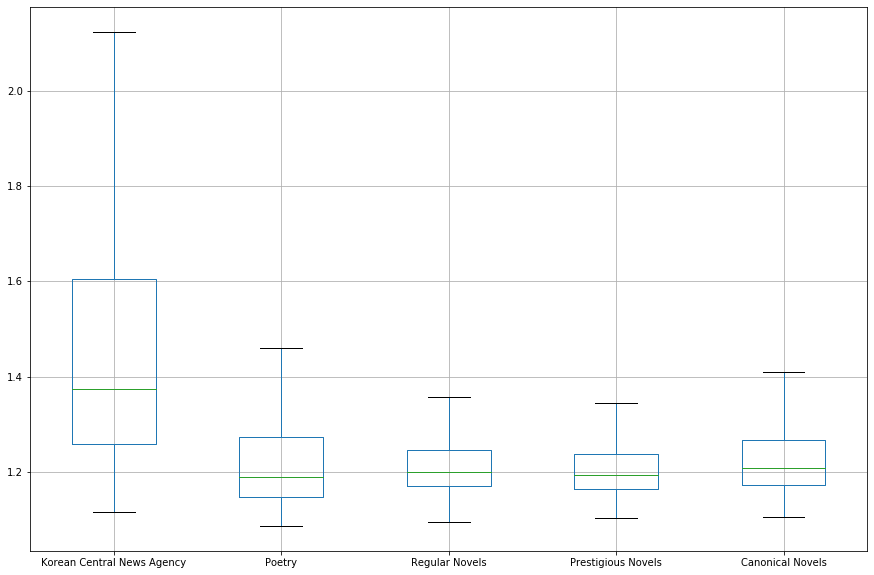

In [264]:
%matplotlib inline
df.boxplot(figsize = (15, 10), showfliers=False)

In [265]:
df.describe()

,Korean Central News Agency,Poetry,Regular Novels,Prestigious Novels,Canonical Novels
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.649833,1.341607,1.227589,1.238253,1.252101
std,1.707318,0.981443,0.119894,0.540845,0.315625
min,1.116894,1.087265,1.095778,1.104933,1.105477
25%,1.259229,1.148061,1.170755,1.164369,1.172522
50%,1.374854,1.190122,1.199594,1.193672,1.209262
75%,1.605486,1.273951,1.246480,1.237370,1.267902
max,43.904465,19.920538,3.107724,17.718954,10.202262


In [266]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Korean Central News Agency : Poetry
Ttest_indResult(statistic=4.9494471164408305, pvalue=8.066184049604652e-07)
Korean Central News Agency : Regular Novels
Ttest_indResult(statistic=7.801538929294824, pvalue=9.777285288218657e-15)
Korean Central News Agency : Prestigious Novels
Ttest_indResult(statistic=7.267328740221698, pvalue=5.234129799650201e-13)
Korean Central News Agency : Canonical Novels
Ttest_indResult(statistic=7.244008989919536, pvalue=6.190877985270788e-13)
Poetry : Regular Novels
Ttest_indResult(statistic=3.6466016651076747, pvalue=0.0002725314356621279)
Poetry : Prestigious Novels
Ttest_indResult(statistic=2.9165997961844474, pvalue=0.003578162594268986)
Poetry : Canonical Novels
Ttest_indResult(statistic=2.7454561477557373, pvalue=0.006096806263335551)
Regular Novels : Prestigious Novels
Ttest_indResult(statistic=-0.6086845327864226, pvalue=0.5428027546043934)
Regular Novels : Canonical Novels
Ttest_indResult(statistic=-2.295774535051768, pvalue=0.021791895525157336)
Pr

### Comments

- The method seems to be at least working for discriminating between discursive genres (press writing, fiction, poetry)
- Many verses are more predictable than sentences from prose fiction. This is however unsurprising, as North Korean poetry often contains political slogans or may be entirely composed of praise for one of the Leaders.
- The method shows less significant differences between subgroups of fiction writing. This may be because there's none and all rely, on average, on the same amount of boilerplate. Comparisons between individual writers might be more meaningful. Other possibilities: issues with the fine-tuned model, wrong assumption that the method can be used indiscriminately on any sentence of a text (need to filter at least dialogue, or select for metaphoric sentences with metaphor detection, wrong assumption that the method actually works as intended...)

<hr>

## Code

In [213]:
from transformers import AutoModelWithLMHead, AutoTokenizer
import torch
import logging
import numpy as np
import pickle

logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)

tokenizer = AutoTokenizer.from_pretrained("../jobert")
model = AutoModelWithLMHead.from_pretrained("../jobert")

I0930 12:14:43.295866 14160 configuration_utils.py:262] loading configuration file ../jobert\config.json
I0930 12:14:43.297861 14160 configuration_utils.py:300] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 2,
  "vocab_size": 20839
}

I0930 12:14:43.298859 14160 tokenization_utils_base.py:1167] Model name '../jobert' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-

In [214]:
from konlpy.tag import Komoran
komoran = Komoran()

In [225]:
def compute_word_proba(sequence, word):
    global model, tokenizer
    input_ids = tokenizer.encode(sequence, return_tensors="pt")
    mask_token_index = torch.where(input_ids == tokenizer.mask_token_id)[1]
    token_logits = model(input_ids)[0]
    mask_token_logits = token_logits[0, mask_token_index, :]
    mask_token_logits = torch.softmax(mask_token_logits, dim=1)
    sought_after_token = word
    sought_after_token_id = tokenizer.encode(sought_after_token, add_special_tokens=False, add_prefix_space=True)[0]
    token_score = mask_token_logits[:, sought_after_token_id]
    return token_score.detach().numpy()[0]

def compute_word_by_word_proba(sequence, tokenized=False):
    global tokenizer
    global komoran
    pos_filter = ['VV', 'VA', 'NNG', 'NNP', 'MAG', 'NA', 'SN', 'NR', 'XR'] # we only want to predict verbs, nouns and adjectives
    word_dict = {}
    if not tokenized:
        tokenized_sequence = komoran.pos(sequence)
    else:
        tokenized_sequence = sequence
    sequence = ' '.join([token for token, pos in tokenized_sequence])
    for token, pos in tokenized_sequence:
        #print(token, pos)
        if pos in pos_filter:
            masked_sequence = sequence.replace(token, tokenizer.mask_token)
            word_dict[token] = compute_word_proba(masked_sequence, token)
    return word_dict

def geometric_mean(series):
    return np.array(series, dtype=np.float64).prod()**(1.0/len(series))

def compute_sentence_score(sentence, tokenized=False):
    return geometric_mean(list(compute_word_by_word_proba(sentence, tokenized).values()))

def compute_sentence_log_likelihood(sentence, tokenized=False):
    return 1/abs(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence, tokenized).values())]))

def compute_sentence_pseudo_perplexity(sentence, tokenized=False):
    return np.exp(-1/(np.mean([np.log(p) for p in list(compute_word_by_word_proba(sentence, tokenized).values())])))

In [226]:
seq = '젊은이들은 조심히 김진수의 낯빛을 살피며 한숨을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq))
seq2 = '젊은이들은 조심히 김진수의 낯빛을 살피며 음식을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq2))
seq3 = '젊은이들은 조심히 김진수의 낯빛을 살피며 도서관을 삼켰다.'
print(compute_sentence_pseudo_perplexity(seq3))

1.1840551468688112
1.1708098991240796
1.1493132982953256


In [227]:
compute_sentence_pseudo_perplexity(komoran.pos(seq3), True)

1.1493132982953256

### With a pre-processed corpus

In [257]:
import pickle
with open('processed_corpus.pkl', 'rb') as fp:
    processed_corpus = pickle.load(fp)

In [259]:
final_results = {}
for corpus in processed_corpus.keys():
    scores = []
    print(corpus)
    for tokenized_sentence in tqdm(processed_corpus[corpus]['tokens'][:1000]):
        try:
            score = compute_sentence_pseudo_perplexity(tokenized_sentence, tokenized=True)
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    final_results[corpus] = scores

Korean Central News Agency




  0%|                                                                                                                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                       | 1/1000 [00:00<07:30,  2.22it/s]

  0%|▎                                                                                                                                                                       | 2/1000 [00:04<25:05,  1.51s/it]

  0%|▌                                                                                                                                                                       | 3/1000 [00:06<27:41,  1.67s/it]

  0%|▋                                                                                                                                                                

  4%|██████▌                                                                                                                                                                | 39/1000 [00:58<19:46,  1.23s/it]

  4%|██████▋                                                                                                                                                                | 40/1000 [01:00<20:05,  1.26s/it]

  4%|██████▊                                                                                                                                                                | 41/1000 [01:01<19:43,  1.23s/it]

  4%|███████                                                                                                                                                                | 42/1000 [01:02<18:07,  1.14s/it]

  4%|███████▏                                                                                                                                                           

  8%|█████████████                                                                                                                                                          | 78/1000 [01:47<15:34,  1.01s/it]

  8%|█████████████▏                                                                                                                                                         | 79/1000 [01:49<19:28,  1.27s/it]

  8%|█████████████▎                                                                                                                                                         | 80/1000 [01:49<17:22,  1.13s/it]

  8%|█████████████▌                                                                                                                                                         | 81/1000 [01:50<16:26,  1.07s/it]

  8%|█████████████▋                                                                                                                                                     

 12%|███████████████████▍                                                                                                                                                  | 117/1000 [02:48<28:45,  1.95s/it]

 12%|███████████████████▌                                                                                                                                                  | 118/1000 [02:49<23:52,  1.62s/it]

 12%|███████████████████▊                                                                                                                                                  | 119/1000 [02:51<25:30,  1.74s/it]

 12%|███████████████████▉                                                                                                                                                  | 120/1000 [02:51<19:28,  1.33s/it]

 12%|████████████████████                                                                                                                                               

 16%|█████████████████████████▉                                                                                                                                            | 156/1000 [03:28<16:42,  1.19s/it]

 16%|██████████████████████████                                                                                                                                            | 157/1000 [03:29<17:18,  1.23s/it]

 16%|██████████████████████████▏                                                                                                                                           | 158/1000 [03:32<23:30,  1.67s/it]

 16%|██████████████████████████▍                                                                                                                                           | 159/1000 [03:33<22:12,  1.58s/it]

 16%|██████████████████████████▌                                                                                                                                        

 20%|████████████████████████████████▎                                                                                                                                     | 195/1000 [04:14<10:48,  1.24it/s]

 20%|████████████████████████████████▌                                                                                                                                     | 196/1000 [04:19<28:33,  2.13s/it]

 20%|████████████████████████████████▋                                                                                                                                     | 197/1000 [04:21<28:22,  2.12s/it]

 20%|████████████████████████████████▊                                                                                                                                     | 198/1000 [04:22<23:36,  1.77s/it]

 20%|█████████████████████████████████                                                                                                                                  

 23%|██████████████████████████████████████▊                                                                                                                               | 234/1000 [05:13<19:29,  1.53s/it]

 24%|███████████████████████████████████████                                                                                                                               | 235/1000 [05:13<16:08,  1.27s/it]

 24%|███████████████████████████████████████▏                                                                                                                              | 236/1000 [05:14<12:50,  1.01s/it]

 24%|███████████████████████████████████████▎                                                                                                                              | 237/1000 [05:14<11:30,  1.11it/s]

 24%|███████████████████████████████████████▌                                                                                                                           

 27%|█████████████████████████████████████████████▎                                                                                                                        | 273/1000 [06:03<13:48,  1.14s/it]

 27%|█████████████████████████████████████████████▍                                                                                                                        | 274/1000 [06:06<19:54,  1.65s/it]

 28%|█████████████████████████████████████████████▋                                                                                                                        | 275/1000 [06:07<16:50,  1.39s/it]

 28%|█████████████████████████████████████████████▊                                                                                                                        | 276/1000 [06:08<13:56,  1.16s/it]

 28%|█████████████████████████████████████████████▉                                                                                                                     

 31%|███████████████████████████████████████████████████▊                                                                                                                  | 312/1000 [06:46<06:07,  1.87it/s]

 31%|███████████████████████████████████████████████████▉                                                                                                                  | 313/1000 [06:46<05:38,  2.03it/s]

 31%|████████████████████████████████████████████████████                                                                                                                  | 314/1000 [06:48<08:51,  1.29it/s]

 32%|████████████████████████████████████████████████████▎                                                                                                                 | 315/1000 [06:48<07:34,  1.51it/s]

 32%|████████████████████████████████████████████████████▍                                                                                                              

 35%|██████████████████████████████████████████████████████████▎                                                                                                           | 351/1000 [07:26<14:06,  1.30s/it]

 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 352/1000 [07:27<13:26,  1.24s/it]

 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 353/1000 [07:28<11:01,  1.02s/it]

 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 354/1000 [07:31<16:19,  1.52s/it]

 36%|██████████████████████████████████████████████████████████▉                                                                                                        

 39%|████████████████████████████████████████████████████████████████▋                                                                                                     | 390/1000 [08:22<12:41,  1.25s/it]

 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 391/1000 [08:23<13:02,  1.28s/it]

 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 392/1000 [08:26<19:35,  1.93s/it]

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 393/1000 [08:27<15:26,  1.53s/it]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                 

 43%|███████████████████████████████████████████████████████████████████████▏                                                                                              | 429/1000 [09:08<10:10,  1.07s/it]

 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 430/1000 [09:11<13:45,  1.45s/it]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 431/1000 [09:12<12:38,  1.33s/it]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 432/1000 [09:13<12:28,  1.32s/it]

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                           

 47%|█████████████████████████████████████████████████████████████████████████████▋                                                                                        | 468/1000 [10:10<11:37,  1.31s/it]

 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 469/1000 [10:11<11:29,  1.30s/it]

 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 470/1000 [10:12<10:48,  1.22s/it]

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 471/1000 [10:12<08:25,  1.05it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                    

 51%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 507/1000 [11:07<10:25,  1.27s/it]

 51%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 508/1000 [11:11<16:53,  2.06s/it]

 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 509/1000 [11:12<13:28,  1.65s/it]

 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 510/1000 [11:12<09:55,  1.21s/it]

 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                              

 55%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 546/1000 [11:59<10:57,  1.45s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 547/1000 [12:01<12:02,  1.60s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 548/1000 [12:04<14:32,  1.93s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 549/1000 [12:05<11:45,  1.56s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                       

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 585/1000 [12:51<07:21,  1.06s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 586/1000 [12:52<06:17,  1.10it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 587/1000 [12:52<05:55,  1.16it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 588/1000 [12:55<09:22,  1.36s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 624/1000 [13:59<13:25,  2.14s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 625/1000 [14:00<11:58,  1.92s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 626/1000 [14:01<09:26,  1.51s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 627/1000 [14:01<07:09,  1.15s/it]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 663/1000 [15:12<07:37,  1.36s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 664/1000 [15:13<06:54,  1.23s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 665/1000 [15:22<21:29,  3.85s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 666/1000 [15:23<16:05,  2.89s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 702/1000 [16:17<05:30,  1.11s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 703/1000 [16:19<06:57,  1.41s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 704/1000 [16:22<09:02,  1.83s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 705/1000 [16:24<09:04,  1.85s/it]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 741/1000 [17:07<03:49,  1.13it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 742/1000 [17:10<06:49,  1.59s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 743/1000 [17:11<06:43,  1.57s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 744/1000 [17:12<05:02,  1.18s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 780/1000 [18:09<04:21,  1.19s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 781/1000 [18:10<03:56,  1.08s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 782/1000 [18:10<03:07,  1.16it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 783/1000 [18:11<02:41,  1.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 819/1000 [19:02<03:29,  1.16s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 820/1000 [19:04<04:04,  1.36s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 821/1000 [19:04<03:06,  1.04s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 822/1000 [19:08<05:30,  1.86s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 858/1000 [19:49<03:53,  1.65s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 859/1000 [19:49<02:57,  1.26s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 860/1000 [19:50<02:31,  1.08s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 861/1000 [19:51<02:12,  1.05it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    

Error: 구석진 곳에 녀학생 둘이 사든 레코드판을 놓고 소곤소곤 이야기를 나누고있었다.
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 7918820 bytes. Buy new RAM!




 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 869/1000 [20:06<05:30,  2.52s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 870/1000 [20:07<04:52,  2.25s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 871/1000 [20:08<03:44,  1.74s/it]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 872/1000 [20:08<02:55,  1.37s/it]

Error: 구석진 곳에 녀학생 둘이 사든 레코드판을 놓고 소곤소곤 이야기를 나누고있었다.
[enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1744896 bytes. Buy new RAM!




 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 874/1000 [20:10<02:33,  1.22s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 875/1000 [20:12<03:12,  1.54s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 876/1000 [20:15<04:00,  1.94s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 877/1000 [20:16<03:09,  1.54s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 913/1000 [21:10<01:34,  1.08s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 914/1000 [21:13<02:17,  1.60s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 915/1000 [21:14<02:01,  1.43s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 916/1000 [21:16<02:23,  1.71s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 952/1000 [22:12<02:01,  2.54s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 953/1000 [22:13<01:36,  2.06s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 954/1000 [22:13<01:15,  1.63s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 955/1000 [22:16<01:23,  1.85s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 991/1000 [22:47<00:13,  1.53s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [22:48<00:10,  1.26s/it]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [22:49<00:07,  1.13s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 994/1000 [22:50<00:06,  1.11s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Poetry




  0%|                                                                                                                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                       | 1/1000 [00:00<03:46,  4.42it/s]

  0%|▌                                                                                                                                                                       | 3/1000 [00:00<03:04,  5.40it/s]

  0%|▋                                                                                                                                                                       | 4/1000 [00:00<03:11,  5.20it/s]

  0%|▊                                                                                                                                                                

  6%|██████████                                                                                                                                                             | 60/1000 [00:07<01:56,  8.05it/s]

  6%|██████████▏                                                                                                                                                            | 61/1000 [00:07<01:56,  8.04it/s]

  6%|██████████▎                                                                                                                                                            | 62/1000 [00:07<02:06,  7.44it/s]

  6%|██████████▌                                                                                                                                                            | 63/1000 [00:07<02:25,  6.42it/s]

  6%|██████████▋                                                                                                                                                        

 12%|███████████████████▊                                                                                                                                                  | 119/1000 [00:14<02:02,  7.21it/s]

 12%|███████████████████▉                                                                                                                                                  | 120/1000 [00:14<02:53,  5.08it/s]

 12%|████████████████████                                                                                                                                                  | 121/1000 [00:14<02:37,  5.60it/s]

 12%|████████████████████▎                                                                                                                                                 | 122/1000 [00:14<02:42,  5.41it/s]

 12%|████████████████████▌                                                                                                                                              

 18%|██████████████████████████████▍                                                                                                                                       | 183/1000 [00:21<01:22,  9.93it/s]

 18%|██████████████████████████████▋                                                                                                                                       | 185/1000 [00:21<01:28,  9.21it/s]

 19%|███████████████████████████████                                                                                                                                       | 187/1000 [00:22<01:23,  9.70it/s]

 19%|███████████████████████████████▏                                                                                                                                      | 188/1000 [00:22<01:28,  9.23it/s]

 19%|███████████████████████████████▌                                                                                                                                   

 24%|███████████████████████████████████████▋                                                                                                                              | 239/1000 [00:28<01:29,  8.48it/s]

 24%|███████████████████████████████████████▊                                                                                                                              | 240/1000 [00:28<01:39,  7.62it/s]

 24%|████████████████████████████████████████                                                                                                                              | 241/1000 [00:28<01:39,  7.61it/s]

 24%|████████████████████████████████████████▏                                                                                                                             | 242/1000 [00:28<01:39,  7.62it/s]

 24%|████████████████████████████████████████▎                                                                                                                          

 30%|█████████████████████████████████████████████████▍                                                                                                                    | 298/1000 [00:35<01:39,  7.02it/s]

 30%|█████████████████████████████████████████████████▋                                                                                                                    | 299/1000 [00:35<01:37,  7.22it/s]

 30%|█████████████████████████████████████████████████▊                                                                                                                    | 300/1000 [00:35<01:37,  7.22it/s]

 30%|██████████████████████████████████████████████████▏                                                                                                                   | 302/1000 [00:35<01:27,  8.00it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                

 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 357/1000 [00:42<01:30,  7.08it/s]

 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 359/1000 [00:42<01:17,  8.26it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 360/1000 [00:42<01:38,  6.49it/s]

 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 361/1000 [00:42<01:34,  6.73it/s]

 36%|████████████████████████████████████████████████████████████▎                                                                                                      

 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 417/1000 [00:49<00:59,  9.82it/s]

 42%|█████████████████████████████████████████████████████████████████████▌                                                                                                | 419/1000 [00:49<00:57, 10.14it/s]

 42%|█████████████████████████████████████████████████████████████████████▉                                                                                                | 421/1000 [00:49<00:56, 10.32it/s]

 42%|██████████████████████████████████████████████████████████████████████▏                                                                                               | 423/1000 [00:50<01:12,  7.97it/s]

 42%|██████████████████████████████████████████████████████████████████████▍                                                                                            

 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 484/1000 [00:56<01:01,  8.39it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 486/1000 [00:57<00:57,  8.91it/s]

 49%|████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 487/1000 [00:57<00:58,  8.71it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 489/1000 [00:57<00:54,  9.30it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                 

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 553/1000 [01:04<00:47,  9.36it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 555/1000 [01:04<00:50,  8.76it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 557/1000 [01:04<00:45,  9.79it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 559/1000 [01:05<00:55,  7.90it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 613/1000 [01:11<00:38, 10.02it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 615/1000 [01:11<00:41,  9.34it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 617/1000 [01:12<00:41,  9.23it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 619/1000 [01:12<00:40,  9.52it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                            

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 672/1000 [01:18<00:36,  8.93it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 674/1000 [01:18<00:34,  9.40it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 675/1000 [01:19<00:38,  8.53it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 676/1000 [01:19<00:38,  8.35it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 731/1000 [01:25<00:34,  7.82it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 733/1000 [01:25<00:29,  8.98it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 735/1000 [01:25<00:26, 10.02it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 737/1000 [01:25<00:27,  9.42it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 790/1000 [01:32<00:28,  7.47it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 791/1000 [01:32<00:27,  7.64it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 792/1000 [01:32<00:29,  7.09it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 794/1000 [01:32<00:24,  8.26it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 855/1000 [01:39<00:17,  8.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 857/1000 [01:39<00:16,  8.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 858/1000 [01:39<00:17,  7.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 860/1000 [01:40<00:16,  8.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 915/1000 [01:46<00:11,  7.15it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 917/1000 [01:47<00:09,  8.33it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 918/1000 [01:47<00:11,  7.32it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 920/1000 [01:47<00:09,  8.33it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [01:54<00:02,  8.94it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 976/1000 [01:54<00:02,  8.51it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 977/1000 [01:54<00:02,  8.42it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 979/1000 [01:54<00:02,  8.57it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋

Regular Novels




  0%|                                                                                                                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                       | 1/1000 [00:00<04:24,  3.78it/s]

  0%|▎                                                                                                                                                                       | 2/1000 [00:00<05:09,  3.23it/s]

  0%|▌                                                                                                                                                                       | 3/1000 [00:01<06:12,  2.67it/s]

  0%|▋                                                                                                                                                                

  4%|██████▌                                                                                                                                                                | 39/1000 [00:15<06:24,  2.50it/s]

  4%|██████▋                                                                                                                                                                | 40/1000 [00:15<05:38,  2.84it/s]

  4%|██████▊                                                                                                                                                                | 41/1000 [00:16<06:18,  2.53it/s]

  4%|███████                                                                                                                                                                | 42/1000 [00:16<05:47,  2.76it/s]

  4%|███████▏                                                                                                                                                           

  8%|█████████████                                                                                                                                                          | 78/1000 [00:31<05:20,  2.88it/s]

  8%|█████████████▏                                                                                                                                                         | 79/1000 [00:31<05:33,  2.76it/s]

  8%|█████████████▎                                                                                                                                                         | 80/1000 [00:32<07:04,  2.17it/s]

  8%|█████████████▌                                                                                                                                                         | 81/1000 [00:32<06:27,  2.37it/s]

  8%|█████████████▋                                                                                                                                                     

 12%|███████████████████▍                                                                                                                                                  | 117/1000 [00:47<10:59,  1.34it/s]

 12%|███████████████████▌                                                                                                                                                  | 118/1000 [00:47<08:16,  1.78it/s]

 12%|███████████████████▊                                                                                                                                                  | 119/1000 [00:48<08:23,  1.75it/s]

 12%|███████████████████▉                                                                                                                                                  | 120/1000 [00:48<07:46,  1.88it/s]

 12%|████████████████████                                                                                                                                               

 16%|█████████████████████████▉                                                                                                                                            | 156/1000 [01:09<06:09,  2.29it/s]

 16%|██████████████████████████                                                                                                                                            | 157/1000 [01:09<05:21,  2.62it/s]

 16%|██████████████████████████▏                                                                                                                                           | 158/1000 [01:09<04:11,  3.34it/s]

 16%|██████████████████████████▍                                                                                                                                           | 159/1000 [01:10<05:27,  2.57it/s]

 16%|██████████████████████████▌                                                                                                                                        

 20%|████████████████████████████████▎                                                                                                                                     | 195/1000 [01:28<05:36,  2.39it/s]

 20%|████████████████████████████████▌                                                                                                                                     | 196/1000 [01:28<06:09,  2.18it/s]

 20%|████████████████████████████████▋                                                                                                                                     | 197/1000 [01:28<05:15,  2.54it/s]

 20%|████████████████████████████████▊                                                                                                                                     | 198/1000 [01:29<04:27,  3.00it/s]

 20%|█████████████████████████████████                                                                                                                                  

 24%|███████████████████████████████████████                                                                                                                               | 235/1000 [01:44<04:57,  2.57it/s]

 24%|███████████████████████████████████████▏                                                                                                                              | 236/1000 [01:44<04:08,  3.07it/s]

 24%|███████████████████████████████████████▎                                                                                                                              | 237/1000 [01:45<05:57,  2.13it/s]

 24%|███████████████████████████████████████▌                                                                                                                              | 238/1000 [01:45<05:04,  2.50it/s]

 24%|███████████████████████████████████████▋                                                                                                                           

 27%|█████████████████████████████████████████████▍                                                                                                                        | 274/1000 [02:01<05:39,  2.14it/s]

 28%|█████████████████████████████████████████████▋                                                                                                                        | 275/1000 [02:01<04:57,  2.43it/s]

 28%|█████████████████████████████████████████████▊                                                                                                                        | 276/1000 [02:02<06:51,  1.76it/s]

 28%|█████████████████████████████████████████████▉                                                                                                                        | 277/1000 [02:02<05:50,  2.06it/s]

 28%|██████████████████████████████████████████████▏                                                                                                                    

 31%|███████████████████████████████████████████████████▉                                                                                                                  | 313/1000 [02:19<05:09,  2.22it/s]

 31%|████████████████████████████████████████████████████                                                                                                                  | 314/1000 [02:20<06:29,  1.76it/s]

 32%|████████████████████████████████████████████████████▎                                                                                                                 | 315/1000 [02:20<05:28,  2.08it/s]

 32%|████████████████████████████████████████████████████▍                                                                                                                 | 316/1000 [02:21<05:00,  2.27it/s]

 32%|████████████████████████████████████████████████████▌                                                                                                              

 35%|██████████████████████████████████████████████████████████▍                                                                                                           | 352/1000 [02:34<05:01,  2.15it/s]

 35%|██████████████████████████████████████████████████████████▌                                                                                                           | 353/1000 [02:35<04:59,  2.16it/s]

 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 354/1000 [02:36<06:41,  1.61it/s]

 36%|██████████████████████████████████████████████████████████▉                                                                                                           | 355/1000 [02:36<05:28,  1.96it/s]

 36%|███████████████████████████████████████████████████████████                                                                                                        

 39%|████████████████████████████████████████████████████████████████▉                                                                                                     | 391/1000 [02:51<04:07,  2.46it/s]

 39%|█████████████████████████████████████████████████████████████████                                                                                                     | 392/1000 [02:51<03:38,  2.79it/s]

 39%|█████████████████████████████████████████████████████████████████▏                                                                                                    | 393/1000 [02:52<03:41,  2.74it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 394/1000 [02:52<04:31,  2.24it/s]

 40%|█████████████████████████████████████████████████████████████████▌                                                                                                 

 43%|███████████████████████████████████████████████████████████████████████▍                                                                                              | 430/1000 [03:10<04:54,  1.94it/s]

 43%|███████████████████████████████████████████████████████████████████████▌                                                                                              | 431/1000 [03:10<04:10,  2.27it/s]

 43%|███████████████████████████████████████████████████████████████████████▋                                                                                              | 432/1000 [03:10<03:45,  2.52it/s]

 43%|███████████████████████████████████████████████████████████████████████▉                                                                                              | 433/1000 [03:10<03:13,  2.93it/s]

 43%|████████████████████████████████████████████████████████████████████████                                                                                           

 47%|█████████████████████████████████████████████████████████████████████████████▊                                                                                        | 469/1000 [03:26<02:40,  3.31it/s]

 47%|██████████████████████████████████████████████████████████████████████████████                                                                                        | 470/1000 [03:26<03:21,  2.62it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▏                                                                                       | 471/1000 [03:27<03:23,  2.59it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▎                                                                                       | 472/1000 [03:27<03:41,  2.39it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                    

 51%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 509/1000 [03:43<05:55,  1.38it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 510/1000 [03:43<05:32,  1.47it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 511/1000 [03:43<04:35,  1.77it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 512/1000 [03:44<03:59,  2.04it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                             

 55%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 548/1000 [04:02<02:46,  2.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 549/1000 [04:03<02:43,  2.75it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 550/1000 [04:03<03:39,  2.05it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 551/1000 [04:06<08:00,  1.07s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                       

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 587/1000 [04:23<02:55,  2.35it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 588/1000 [04:24<04:35,  1.50it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 589/1000 [04:24<03:58,  1.72it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 590/1000 [04:24<03:18,  2.07it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                 

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 627/1000 [04:42<02:49,  2.19it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 628/1000 [04:43<02:31,  2.45it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 629/1000 [04:43<02:26,  2.54it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 630/1000 [04:44<02:44,  2.25it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 666/1000 [05:01<02:50,  1.95it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 667/1000 [05:01<02:22,  2.33it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 668/1000 [05:01<02:24,  2.30it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 669/1000 [05:02<02:09,  2.55it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 707/1000 [05:19<02:21,  2.07it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 708/1000 [05:19<02:00,  2.43it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 709/1000 [05:20<02:21,  2.06it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 710/1000 [05:20<02:25,  1.99it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 746/1000 [05:38<01:36,  2.64it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 747/1000 [05:38<01:30,  2.79it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 748/1000 [05:39<01:39,  2.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 749/1000 [05:39<01:44,  2.41it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 785/1000 [05:56<02:11,  1.64it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 786/1000 [05:57<02:17,  1.56it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 787/1000 [05:57<01:44,  2.04it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 788/1000 [05:58<01:47,  1.96it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 824/1000 [06:15<01:08,  2.59it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 825/1000 [06:15<01:09,  2.52it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 826/1000 [06:16<01:10,  2.47it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 827/1000 [06:16<00:55,  3.09it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 863/1000 [06:32<00:59,  2.32it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 864/1000 [06:34<01:49,  1.24it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 865/1000 [06:34<01:21,  1.66it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 866/1000 [06:34<01:07,  1.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 902/1000 [06:50<00:27,  3.51it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 903/1000 [06:50<00:27,  3.49it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 904/1000 [06:52<00:54,  1.77it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 905/1000 [06:52<00:55,  1.72it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 942/1000 [07:06<00:25,  2.29it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 943/1000 [07:06<00:22,  2.51it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 944/1000 [07:07<00:20,  2.74it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 945/1000 [07:07<00:21,  2.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 982/1000 [07:24<00:08,  2.15it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [07:25<00:07,  2.39it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [07:25<00:06,  2.45it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 985/1000 [07:25<00:05,  2.64it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Prestigious Novels




  0%|                                                                                                                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                       | 1/1000 [00:00<09:50,  1.69it/s]

  0%|▎                                                                                                                                                                       | 2/1000 [00:00<08:29,  1.96it/s]

  0%|▌                                                                                                                                                                       | 3/1000 [00:01<09:23,  1.77it/s]

  0%|▋                                                                                                                                                                

  4%|██████▌                                                                                                                                                                | 39/1000 [00:19<07:40,  2.09it/s]

  4%|██████▋                                                                                                                                                                | 40/1000 [00:20<08:51,  1.81it/s]

  4%|██████▊                                                                                                                                                                | 41/1000 [00:20<07:18,  2.19it/s]

  4%|███████                                                                                                                                                                | 42/1000 [00:21<07:09,  2.23it/s]

  4%|███████▏                                                                                                                                                           

  8%|█████████████                                                                                                                                                          | 78/1000 [00:38<04:37,  3.32it/s]

  8%|█████████████▏                                                                                                                                                         | 79/1000 [00:39<05:43,  2.68it/s]

  8%|█████████████▎                                                                                                                                                         | 80/1000 [00:39<05:28,  2.80it/s]

  8%|█████████████▌                                                                                                                                                         | 81/1000 [00:39<04:42,  3.26it/s]

  8%|█████████████▋                                                                                                                                                     

 12%|███████████████████▉                                                                                                                                                  | 120/1000 [01:02<06:59,  2.10it/s]

 12%|████████████████████                                                                                                                                                  | 121/1000 [01:03<07:15,  2.02it/s]

 12%|████████████████████▎                                                                                                                                                 | 122/1000 [01:03<07:38,  1.92it/s]

 12%|████████████████████▍                                                                                                                                                 | 123/1000 [01:04<08:54,  1.64it/s]

 12%|████████████████████▌                                                                                                                                              

 16%|██████████████████████████▍                                                                                                                                           | 159/1000 [01:25<06:10,  2.27it/s]

 16%|██████████████████████████▌                                                                                                                                           | 160/1000 [01:26<06:13,  2.25it/s]

 16%|██████████████████████████▋                                                                                                                                           | 161/1000 [01:26<05:25,  2.58it/s]

 16%|██████████████████████████▉                                                                                                                                           | 162/1000 [01:27<06:28,  2.15it/s]

 16%|███████████████████████████                                                                                                                                        

 20%|████████████████████████████████▊                                                                                                                                     | 198/1000 [01:50<05:54,  2.26it/s]

 20%|█████████████████████████████████                                                                                                                                     | 199/1000 [01:51<11:31,  1.16it/s]

 20%|█████████████████████████████████▏                                                                                                                                    | 200/1000 [01:52<08:42,  1.53it/s]

 20%|█████████████████████████████████▎                                                                                                                                    | 201/1000 [01:52<08:39,  1.54it/s]

 20%|█████████████████████████████████▌                                                                                                                                 

 24%|███████████████████████████████████████▎                                                                                                                              | 237/1000 [02:10<04:24,  2.88it/s]

 24%|███████████████████████████████████████▌                                                                                                                              | 238/1000 [02:11<03:47,  3.35it/s]

 24%|███████████████████████████████████████▋                                                                                                                              | 239/1000 [02:11<03:32,  3.58it/s]

 24%|███████████████████████████████████████▊                                                                                                                              | 240/1000 [02:12<04:49,  2.62it/s]

 24%|████████████████████████████████████████                                                                                                                           

 28%|█████████████████████████████████████████████▊                                                                                                                        | 276/1000 [02:27<05:04,  2.37it/s]

 28%|█████████████████████████████████████████████▉                                                                                                                        | 277/1000 [02:27<04:33,  2.65it/s]

 28%|██████████████████████████████████████████████▏                                                                                                                       | 278/1000 [02:29<09:30,  1.27it/s]

 28%|██████████████████████████████████████████████▎                                                                                                                       | 279/1000 [02:30<08:15,  1.46it/s]

 28%|██████████████████████████████████████████████▍                                                                                                                    

 32%|████████████████████████████████████████████████████▎                                                                                                                 | 315/1000 [02:44<03:20,  3.42it/s]

 32%|████████████████████████████████████████████████████▍                                                                                                                 | 316/1000 [02:44<03:31,  3.23it/s]

 32%|████████████████████████████████████████████████████▌                                                                                                                 | 317/1000 [02:45<03:55,  2.90it/s]

 32%|████████████████████████████████████████████████████▊                                                                                                                 | 318/1000 [02:45<04:21,  2.61it/s]

 32%|████████████████████████████████████████████████████▉                                                                                                              

 35%|██████████████████████████████████████████████████████████▊                                                                                                           | 354/1000 [03:04<06:37,  1.63it/s]

 36%|██████████████████████████████████████████████████████████▉                                                                                                           | 355/1000 [03:05<06:53,  1.56it/s]

 36%|███████████████████████████████████████████████████████████                                                                                                           | 356/1000 [03:06<08:02,  1.34it/s]

 36%|███████████████████████████████████████████████████████████▎                                                                                                          | 357/1000 [03:08<12:01,  1.12s/it]

 36%|███████████████████████████████████████████████████████████▍                                                                                                       

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                    | 394/1000 [03:23<05:28,  1.84it/s]

 40%|█████████████████████████████████████████████████████████████████▌                                                                                                    | 395/1000 [03:24<04:14,  2.38it/s]

 40%|█████████████████████████████████████████████████████████████████▋                                                                                                    | 396/1000 [03:24<03:30,  2.87it/s]

 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 397/1000 [03:24<03:28,  2.89it/s]

 40%|██████████████████████████████████████████████████████████████████                                                                                                 

 43%|████████████████████████████████████████████████████████████████████████                                                                                              | 434/1000 [03:37<03:09,  2.99it/s]

 44%|████████████████████████████████████████████████████████████████████████▏                                                                                             | 435/1000 [03:38<02:52,  3.27it/s]

 44%|████████████████████████████████████████████████████████████████████████▍                                                                                             | 436/1000 [03:38<02:56,  3.19it/s]

 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 437/1000 [03:38<02:51,  3.27it/s]

 44%|████████████████████████████████████████████████████████████████████████▋                                                                                          

 47%|██████████████████████████████████████████████████████████████████████████████▌                                                                                       | 473/1000 [03:57<04:12,  2.09it/s]

 47%|██████████████████████████████████████████████████████████████████████████████▋                                                                                       | 474/1000 [03:57<03:43,  2.35it/s]

 48%|██████████████████████████████████████████████████████████████████████████████▊                                                                                       | 475/1000 [03:58<03:25,  2.55it/s]

 48%|███████████████████████████████████████████████████████████████████████████████                                                                                       | 476/1000 [03:58<03:31,  2.47it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                   

 51%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 512/1000 [04:13<02:53,  2.81it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 513/1000 [04:13<03:24,  2.38it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 514/1000 [04:15<05:50,  1.39it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 515/1000 [04:15<05:25,  1.49it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                             

 55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 552/1000 [04:34<03:33,  2.10it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 553/1000 [04:35<03:10,  2.34it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 554/1000 [04:35<02:40,  2.77it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 555/1000 [04:36<03:39,  2.03it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 591/1000 [04:54<03:18,  2.06it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 592/1000 [04:55<04:09,  1.63it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 593/1000 [04:55<03:49,  1.77it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 594/1000 [04:56<03:31,  1.92it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 630/1000 [05:13<02:56,  2.10it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 631/1000 [05:14<04:52,  1.26it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 632/1000 [05:15<04:01,  1.53it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 633/1000 [05:15<03:49,  1.60it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 669/1000 [05:39<02:22,  2.32it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 670/1000 [05:40<02:04,  2.64it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 671/1000 [05:40<02:25,  2.27it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 672/1000 [05:41<02:14,  2.44it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 708/1000 [06:00<02:35,  1.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 709/1000 [06:00<02:24,  2.01it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 710/1000 [06:00<01:59,  2.43it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 711/1000 [06:01<01:54,  2.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 748/1000 [06:24<02:49,  1.49it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 749/1000 [06:24<02:22,  1.77it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 750/1000 [06:25<02:18,  1.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 751/1000 [06:25<02:13,  1.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 787/1000 [06:45<01:17,  2.75it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 788/1000 [06:45<01:10,  3.01it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 789/1000 [06:46<01:51,  1.89it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 790/1000 [06:47<01:28,  2.38it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 826/1000 [07:11<01:05,  2.64it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 827/1000 [07:13<01:49,  1.58it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 828/1000 [07:13<01:35,  1.80it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 829/1000 [07:13<01:14,  2.29it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 866/1000 [07:31<01:33,  1.44it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 867/1000 [07:31<01:11,  1.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 868/1000 [07:32<01:30,  1.45it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 869/1000 [07:33<01:24,  1.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 905/1000 [07:56<00:42,  2.24it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 906/1000 [07:56<00:35,  2.62it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 907/1000 [07:56<00:34,  2.70it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 908/1000 [07:56<00:28,  3.22it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 945/1000 [08:13<00:27,  2.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 946/1000 [08:13<00:24,  2.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 947/1000 [08:13<00:25,  2.05it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 948/1000 [08:14<00:23,  2.21it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [08:32<00:08,  1.91it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 985/1000 [08:33<00:07,  1.92it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [08:33<00:06,  2.25it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [08:34<00:08,  1.60it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Canonical Novels




  0%|                                                                                                                                                                                | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                                       | 1/1000 [00:00<11:07,  1.50it/s]

  0%|▎                                                                                                                                                                       | 2/1000 [00:01<10:28,  1.59it/s]

  0%|▌                                                                                                                                                                       | 3/1000 [00:02<11:55,  1.39it/s]

  0%|▋                                                                                                                                                                

  4%|██████▌                                                                                                                                                                | 39/1000 [00:19<08:49,  1.82it/s]

  4%|██████▋                                                                                                                                                                | 40/1000 [00:20<10:12,  1.57it/s]

  4%|██████▊                                                                                                                                                                | 41/1000 [00:20<08:43,  1.83it/s]

  4%|███████                                                                                                                                                                | 42/1000 [00:21<08:51,  1.80it/s]

  4%|███████▏                                                                                                                                                           

  8%|█████████████                                                                                                                                                          | 78/1000 [00:40<05:51,  2.62it/s]

  8%|█████████████▏                                                                                                                                                         | 79/1000 [00:41<08:17,  1.85it/s]

  8%|█████████████▎                                                                                                                                                         | 80/1000 [00:41<07:21,  2.09it/s]

  8%|█████████████▌                                                                                                                                                         | 81/1000 [00:41<06:43,  2.28it/s]

  8%|█████████████▋                                                                                                                                                     

 12%|███████████████████▌                                                                                                                                                  | 118/1000 [01:02<07:19,  2.01it/s]

 12%|███████████████████▉                                                                                                                                                  | 120/1000 [01:03<06:11,  2.37it/s]

 12%|████████████████████                                                                                                                                                  | 121/1000 [01:03<06:22,  2.30it/s]

 12%|████████████████████▎                                                                                                                                                 | 122/1000 [01:03<06:11,  2.37it/s]

 12%|████████████████████▍                                                                                                                                              

 16%|██████████████████████████▍                                                                                                                                           | 159/1000 [01:25<09:45,  1.44it/s]

 16%|██████████████████████████▌                                                                                                                                           | 160/1000 [01:25<08:11,  1.71it/s]

 16%|██████████████████████████▋                                                                                                                                           | 161/1000 [01:25<07:37,  1.83it/s]

 16%|██████████████████████████▉                                                                                                                                           | 162/1000 [01:26<07:40,  1.82it/s]

 16%|███████████████████████████                                                                                                                                        

 20%|████████████████████████████████▊                                                                                                                                     | 198/1000 [01:41<07:55,  1.69it/s]

 20%|█████████████████████████████████                                                                                                                                     | 199/1000 [01:42<06:04,  2.20it/s]

 20%|█████████████████████████████████▏                                                                                                                                    | 200/1000 [01:42<05:03,  2.64it/s]

 20%|█████████████████████████████████▎                                                                                                                                    | 201/1000 [01:42<04:51,  2.74it/s]

 20%|█████████████████████████████████▌                                                                                                                                 

 24%|███████████████████████████████████████▎                                                                                                                              | 237/1000 [02:00<05:43,  2.22it/s]

 24%|███████████████████████████████████████▌                                                                                                                              | 238/1000 [02:00<05:36,  2.26it/s]

 24%|███████████████████████████████████████▋                                                                                                                              | 239/1000 [02:01<05:35,  2.27it/s]

 24%|███████████████████████████████████████▊                                                                                                                              | 240/1000 [02:01<05:06,  2.48it/s]

 24%|████████████████████████████████████████                                                                                                                           

 28%|█████████████████████████████████████████████▉                                                                                                                        | 277/1000 [02:20<04:55,  2.45it/s]

 28%|██████████████████████████████████████████████▏                                                                                                                       | 278/1000 [02:21<05:02,  2.39it/s]

 28%|██████████████████████████████████████████████▎                                                                                                                       | 279/1000 [02:21<04:21,  2.76it/s]

 28%|██████████████████████████████████████████████▍                                                                                                                       | 280/1000 [02:22<06:37,  1.81it/s]

 28%|██████████████████████████████████████████████▋                                                                                                                    

 32%|████████████████████████████████████████████████████▌                                                                                                                 | 317/1000 [02:42<05:49,  1.95it/s]

 32%|████████████████████████████████████████████████████▉                                                                                                                 | 319/1000 [02:42<04:24,  2.58it/s]

 32%|█████████████████████████████████████████████████████                                                                                                                 | 320/1000 [02:42<03:56,  2.88it/s]

 32%|█████████████████████████████████████████████████████▎                                                                                                                | 321/1000 [02:43<04:45,  2.37it/s]

 32%|█████████████████████████████████████████████████████▍                                                                                                             

 36%|███████████████████████████████████████████████████████████▍                                                                                                          | 358/1000 [03:03<04:32,  2.35it/s]

 36%|███████████████████████████████████████████████████████████▌                                                                                                          | 359/1000 [03:03<04:12,  2.54it/s]

 36%|███████████████████████████████████████████████████████████▊                                                                                                          | 360/1000 [03:04<03:45,  2.83it/s]

 36%|███████████████████████████████████████████████████████████▉                                                                                                          | 361/1000 [03:04<03:34,  2.98it/s]

 36%|████████████████████████████████████████████████████████████                                                                                                       

 40%|█████████████████████████████████████████████████████████████████▉                                                                                                    | 397/1000 [03:24<03:37,  2.78it/s]

 40%|██████████████████████████████████████████████████████████████████                                                                                                    | 398/1000 [03:26<07:56,  1.26it/s]

 40%|██████████████████████████████████████████████████████████████████▏                                                                                                   | 399/1000 [03:26<06:31,  1.53it/s]

 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 400/1000 [03:26<04:57,  2.01it/s]

 40%|██████████████████████████████████████████████████████████████████▌                                                                                                

 44%|████████████████████████████████████████████████████████████████████████▌                                                                                             | 437/1000 [03:45<02:42,  3.46it/s]

 44%|████████████████████████████████████████████████████████████████████████▋                                                                                             | 438/1000 [03:46<02:58,  3.15it/s]

 44%|████████████████████████████████████████████████████████████████████████▊                                                                                             | 439/1000 [03:46<03:16,  2.86it/s]

 44%|█████████████████████████████████████████████████████████████████████████                                                                                             | 440/1000 [03:47<03:45,  2.49it/s]

 44%|█████████████████████████████████████████████████████████████████████████▏                                                                                         

 48%|███████████████████████████████████████████████████████████████████████████████▏                                                                                      | 477/1000 [04:03<03:12,  2.71it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▎                                                                                      | 478/1000 [04:04<03:34,  2.43it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▌                                                                                      | 479/1000 [04:04<03:48,  2.28it/s]

 48%|███████████████████████████████████████████████████████████████████████████████▋                                                                                      | 480/1000 [04:05<03:44,  2.32it/s]

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                   

 52%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 518/1000 [04:22<02:22,  3.39it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 519/1000 [04:23<02:48,  2.86it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 520/1000 [04:23<02:28,  3.23it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 521/1000 [04:23<02:21,  3.39it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                            

 56%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 557/1000 [04:41<02:38,  2.79it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 558/1000 [04:41<03:24,  2.16it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 559/1000 [04:42<03:06,  2.36it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 560/1000 [04:42<02:52,  2.55it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 596/1000 [05:01<03:04,  2.19it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 597/1000 [05:01<02:33,  2.62it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 598/1000 [05:03<05:07,  1.31it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 599/1000 [05:03<04:24,  1.52it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 638/1000 [05:25<03:35,  1.68it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 639/1000 [05:25<03:04,  1.95it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 640/1000 [05:26<03:33,  1.68it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 641/1000 [05:26<02:46,  2.15it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 677/1000 [05:44<02:44,  1.97it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 678/1000 [05:45<02:34,  2.08it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 679/1000 [05:45<02:19,  2.30it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 680/1000 [05:47<04:35,  1.16it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 716/1000 [06:05<03:30,  1.35it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 717/1000 [06:05<03:07,  1.51it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 718/1000 [06:06<02:39,  1.76it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 719/1000 [06:06<02:40,  1.75it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 755/1000 [06:24<02:09,  1.89it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 756/1000 [06:24<01:51,  2.18it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 757/1000 [06:25<01:50,  2.20it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 758/1000 [06:25<01:47,  2.25it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 794/1000 [06:43<01:21,  2.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 795/1000 [06:44<01:29,  2.30it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 796/1000 [06:45<01:38,  2.07it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 797/1000 [06:45<01:29,  2.28it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 833/1000 [07:03<00:54,  3.05it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 834/1000 [07:04<00:54,  3.04it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 835/1000 [07:04<01:13,  2.25it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 836/1000 [07:05<01:31,  1.80it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 872/1000 [07:19<00:53,  2.41it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 873/1000 [07:19<00:46,  2.75it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 874/1000 [07:19<00:39,  3.22it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 875/1000 [07:20<00:42,  2.97it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 911/1000 [07:39<01:11,  1.24it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 912/1000 [07:40<01:16,  1.16it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 913/1000 [07:41<01:19,  1.09it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 914/1000 [07:41<01:02,  1.38it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 950/1000 [07:57<00:19,  2.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 951/1000 [07:58<00:24,  1.97it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 952/1000 [07:58<00:20,  2.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 953/1000 [07:58<00:17,  2.62it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [08:14<00:04,  2.61it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [08:14<00:03,  2.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 991/1000 [08:15<00:03,  2.34it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [08:15<00:02,  2.74it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

### With a non pre-processed corpus

In [217]:
import os
from tqdm import tqdm


sample_data_path = './samples'
sample_files = [file for file in os.listdir(sample_data_path) if not file.endswith('-tokenized.txt')]
final_results = {}
for file in sample_files:
    with open(os.path.join(sample_data_path, file), 'r', encoding='utf8') as fp:
        sentences = fp.read().splitlines()
    scores = []
    print(file)
    for i, sentence in enumerate(tqdm(sentences[:50])):
        try:
            score = compute_sentence_pseudo_perplexity(sentence.replace('\xa0 ', ''))
            scores.append(score)
        except Exception as e:
            scores.append(np.mean(scores))
            print("Error:", sentence)
            print(e)
            pass
    
    final_results[file] = scores
    
#with open('/project/RDS-FASS-NKBert-RW/samples/final_scores.pkl', 'wb') as fp:
#    pickle.dump(final_results, fp)


Canonical Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:01<00:48,  1.00it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:01<00:38,  1.24it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:31,  1.49it/s]

  8%|█████████████▌                                                                                                                                                   

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39/50 [00:44<00:12,  1.12s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 40/50 [00:45<00:09,  1.02it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 41/50 [00:45<00:07,  1.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 42/50 [00:46<00:06,  1.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 

Central News Agency.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:01<01:04,  1.31s/it]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:04<01:23,  1.75s/it]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:04<01:08,  1.45s/it]

  8%|█████████████▌                                                                                                                                                   

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39/50 [00:56<00:21,  1.96s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 40/50 [00:57<00:17,  1.75s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 41/50 [01:03<00:27,  3.06s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 42/50 [01:05<00:22,  2.86s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 

Poetry.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:14,  3.39it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:13,  3.61it/s]

  8%|█████████████▌                                                                                                                                                            | 4/50 [00:00<00:10,  4.56it/s]

 12%|████████████████████▍                                                                                                                                            

Prestigious Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:12,  3.96it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:16,  2.87it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:14,  3.19it/s]

  8%|█████████████▌                                                                                                                                                   

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39/50 [00:30<00:05,  1.97it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 40/50 [00:31<00:05,  1.89it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 41/50 [00:31<00:04,  1.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 42/50 [00:32<00:04,  1.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 

Regular Novels.txt




  0%|                                                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

  2%|███▍                                                                                                                                                                      | 1/50 [00:00<00:23,  2.07it/s]

  4%|██████▊                                                                                                                                                                   | 2/50 [00:00<00:20,  2.32it/s]

  6%|██████████▏                                                                                                                                                               | 3/50 [00:01<00:20,  2.24it/s]

  8%|█████████████▌                                                                                                                                                   

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 39/50 [00:27<00:13,  1.20s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 40/50 [00:27<00:10,  1.00s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 41/50 [00:29<00:11,  1.33s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 42/50 [00:31<00:12,  1.51s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 

### Outputing results

In [260]:
import pandas as pd
df = pd.DataFrame(final_results)
df

,Korean Central News Agency,Poetry,Regular Novels,Prestigious Novels,Canonical Novels
0,1.621643,2.012268,1.155405,1.130619,1.262040
1,1.588213,1.375887,1.197784,1.219334,1.212808
2,1.645163,1.147946,1.211390,1.195010,1.246667
3,1.254009,1.108578,1.241670,1.135918,1.216497
4,1.142635,1.122965,1.233411,1.169411,1.341588
...,...,...,...,...,...
995,1.177524,1.146012,1.209488,1.133399,1.163098
996,1.249583,1.961950,1.200817,1.156499,1.162825
997,7.977462,1.332545,1.207410,1.149221,1.148337
998,1.324241,1.244402,1.266944,1.162261,1.283745


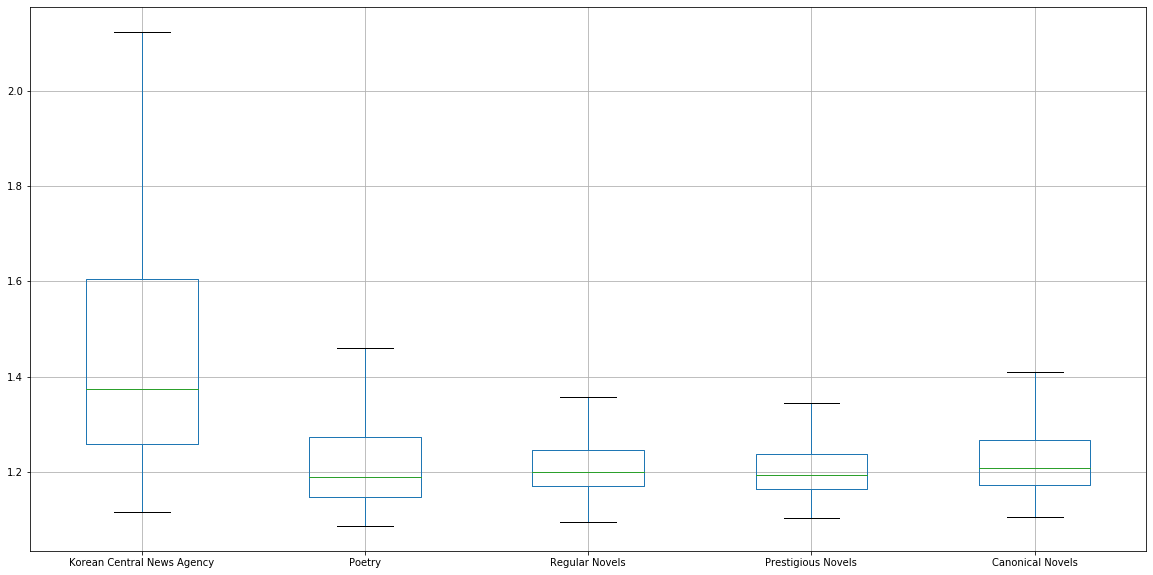

In [261]:
%matplotlib inline
df.boxplot(figsize = (20, 10), showfliers=False)

In [262]:
df.describe()

,Korean Central News Agency,Poetry,Regular Novels,Prestigious Novels,Canonical Novels
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.649833,1.341607,1.227589,1.238253,1.252101
std,1.707318,0.981443,0.119894,0.540845,0.315625
min,1.116894,1.087265,1.095778,1.104933,1.105477
25%,1.259229,1.148061,1.170755,1.164369,1.172522
50%,1.374854,1.190122,1.199594,1.193672,1.209262
75%,1.605486,1.273951,1.246480,1.237370,1.267902
max,43.904465,19.920538,3.107724,17.718954,10.202262


In [263]:
from scipy import stats
from itertools import combinations
for a, b in list(combinations(df.columns, 2)):
    print(f'{a} : {b}')
    print(stats.ttest_ind(df[a],df[b]))

Korean Central News Agency : Poetry
Ttest_indResult(statistic=4.9494471164408305, pvalue=8.066184049604652e-07)
Korean Central News Agency : Regular Novels
Ttest_indResult(statistic=7.801538929294824, pvalue=9.777285288218657e-15)
Korean Central News Agency : Prestigious Novels
Ttest_indResult(statistic=7.267328740221698, pvalue=5.234129799650201e-13)
Korean Central News Agency : Canonical Novels
Ttest_indResult(statistic=7.244008989919536, pvalue=6.190877985270788e-13)
Poetry : Regular Novels
Ttest_indResult(statistic=3.6466016651076747, pvalue=0.0002725314356621279)
Poetry : Prestigious Novels
Ttest_indResult(statistic=2.9165997961844474, pvalue=0.003578162594268986)
Poetry : Canonical Novels
Ttest_indResult(statistic=2.7454561477557373, pvalue=0.006096806263335551)
Regular Novels : Prestigious Novels
Ttest_indResult(statistic=-0.6086845327864226, pvalue=0.5428027546043934)
Regular Novels : Canonical Novels
Ttest_indResult(statistic=-2.295774535051768, pvalue=0.021791895525157336)
Pr